In [1]:
import pandas as pd
import os
import requests
from acquire import get_items, new_stores, get_stores, get_sales, combined_data, get_germany_power
from prepare import prep_combine, prep_opsd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    yhat_df = pd.DataFrame({'amount': [amounts],
                           }, index = validate.index)
    return yhat_df

In [3]:
df = pd.read_csv('saas.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.columns=['date','cust_id','invoice_id','sub_type','amount']

In [6]:
df['date'] = pd.to_datetime(df.date)
df

,date,cust_id,invoice_id,sub_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [7]:
df = df.groupby(['date']).amount.sum().reset_index()

In [8]:
df = df[df.index!='2016-02-29']

In [9]:
df = df.set_index('date').sort_index()

In [10]:
df.head(2)

,amount
date,
2014-01-31,35850.0
2014-02-28,37190.0


1.) Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [11]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [12]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [13]:
len(train) + len(validate) + len(test) == len(df)

True

In [14]:
print(df.head(1) ==train.head(1))

            amount
date              
2014-01-31    True


In [15]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,amount
date,
2017-02-28,53440.0
2017-03-31,53480.0


In [16]:
pd.concat([test.tail(1), df.tail(1)])

,amount
date,
2017-12-31,53805.0
2017-12-31,53805.0


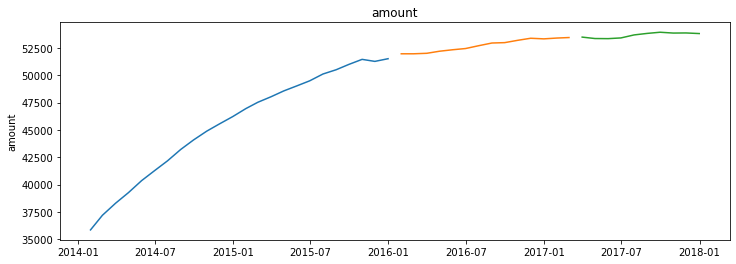

In [17]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [18]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

2.) Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
Simple Average

In [19]:
amounts = round(train['amount'].mean(),2)

In [20]:
yhat_df = make_predictions()

In [21]:
yhat_df.head()

,amount
date,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


amount -- RMSE: 7181


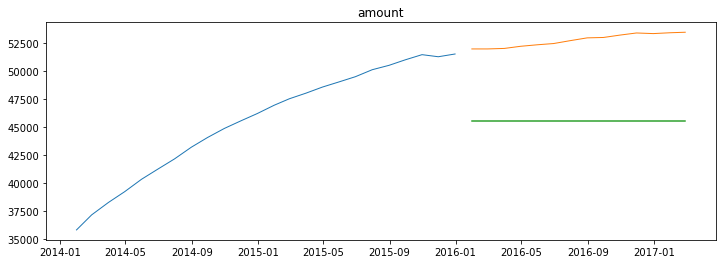

In [22]:
for col in train.columns:
    plot_and_eval(col)

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [24]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0


In [25]:
period = 2

amounts = round(train['amount'].rolling(period).mean().iloc[-1], 2)


yhat_df = make_predictions()
yhat_df.head(3)

,amount
date,
2016-01-31,51382.5
2016-02-29,51382.5
2016-03-31,51382.5


amount -- RMSE: 1455


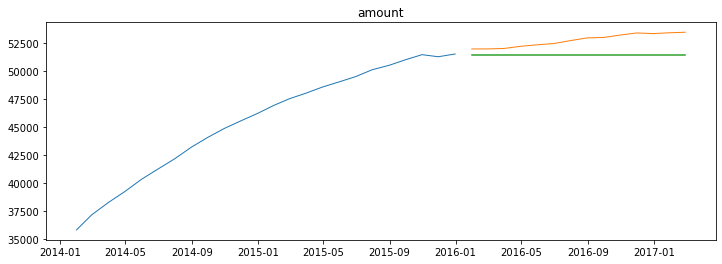

In [26]:
for col in train.columns:
    plot_and_eval(col)


In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type='2 month moving average', 
                             target_var = col)

In [28]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,2 month moving average,amount,1455.0


In [29]:
periods = [3, 4, 5, 6, 8, 12]

for p in periods:
    amounts = round(train['amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )

In [30]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,2 month moving average,amount,1455.0
2,3 month moving average,amount,1436.0
3,4 month moving average,amount,1533.0
4,5 month moving average,amount,1684.0
5,6 month moving average,amount,1847.0
6,8 month moving average,amount,2259.0
7,12 month moving average,amount,3164.0


In [31]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [32]:
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
2,3 month moving average,amount,1436.0


Holt's Linear Trend Model

amount 



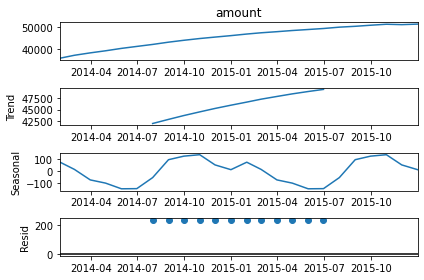

In [33]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [34]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

amount -- RMSE: 8103


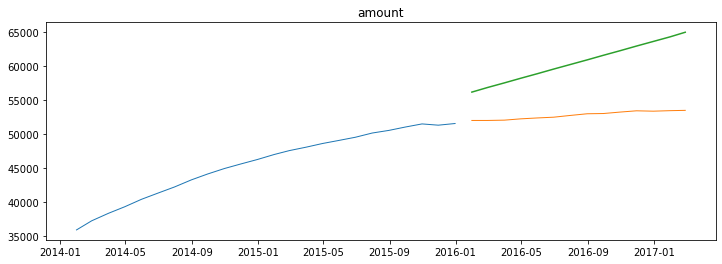

In [35]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [37]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,2 month moving average,amount,1455.0
2,3 month moving average,amount,1436.0
3,4 month moving average,amount,1533.0
4,5 month moving average,amount,1684.0
5,6 month moving average,amount,1847.0
6,8 month moving average,amount,2259.0
7,12 month moving average,amount,3164.0
8,Holts,amount,8103.0


Based on Previous Year

In [38]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [39]:
yhat_df = round(train['2015'] + train.diff(1).mean(),2)

In [40]:
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
date,
2015-01-31,47625.65
2016-01-31,51955.00


In [41]:

yhat_df.index = validate.index

len(yhat_df)

12

amount -- RMSE: 2539


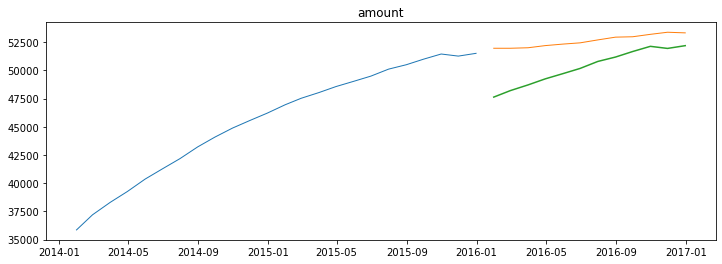

In [42]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [43]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,2 month moving average,amount,1455.0
2,3 month moving average,amount,1436.0
3,4 month moving average,amount,1533.0
4,5 month moving average,amount,1684.0
5,6 month moving average,amount,1847.0
6,8 month moving average,amount,2259.0
7,12 month moving average,amount,3164.0
8,Holts,amount,8103.0
9,previous year,amount,2539.0


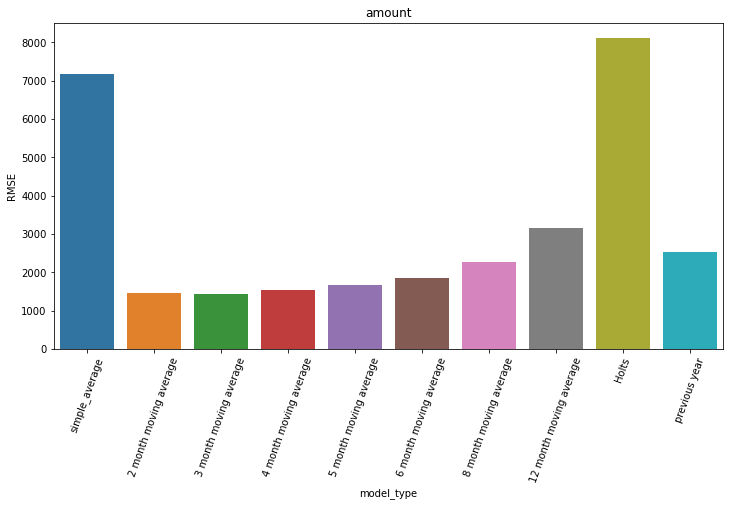

In [52]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=70)
    plt.show()

In [45]:
yhat_df = validate + train.diff(1).mean()
yhat_df.index = test.index

In [46]:
rmse_amount = round(sqrt(mean_squared_error(test['amount'], yhat_df['amount'])), 0)

In [47]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

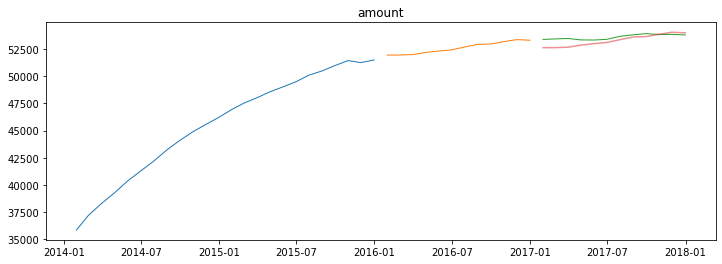

In [48]:
for col in train.columns:
    plot_and_eval(col)

In [49]:
rmse_amount

463.0